In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-retail-ii-data-set-from-ml-repository/Year 2010-2011.csv
/kaggle/input/online-retail-ii-data-set-from-ml-repository/Year 2009-2010.csv
/kaggle/input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx


# What is RFM Analysis ?

#### RFM stands for Recency, Frequency, Monetary Value, and it's a technique used by businesses to analyze their customer's purchasing behavior.

#### Recency: This is about how recently a customer has made a purchase. If a customer has made a purchase more recently, it means they are more engaged with the business and are more likely to make another purchase.

#### Frequency: This is about how often a customer makes purchases. If a customer makes purchases more frequently, it means they are more loyal to the business.

#### Monetary: This is about how much a customer spends on purchases. If a customer spends more money, it means they are more valuable to the business.

#### By analyzing these three factors, businesses can segment their customers into different groups and tailor their marketing strategies to each group. For example, a business might offer a discount to customers who haven't made a purchase recently to encourage them to make another purchase, or offer loyalty rewards to customers who make frequent purchases.


# Column Descriptors
- InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
- UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
- CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal. The name of the country where a customer resides.

In [2]:
df = pd.read_excel("/kaggle/input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx",sheet_name="Year 2010-2011")
dff = df.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# Data Understanding

In [3]:
def data_check(dataframe):
    print("#"*10,"INFO","#"*10)
    print(df.info())
    print("#"*10,"SHAPE","#"*10)
    print(df.shape)
    print("#"*10,"MISSING VALUES","#"*10)
    print(df.isna().sum())
    print("#"*10,"DESCRIBE","#"*10)
    print(df.describe().T)
    
data_check(df)

########## INFO ##########
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
########## SHAPE ##########
(541910, 8)
########## MISSING VALUES ##########
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64
##########

# Drop Missing Values

In [4]:
# Missing Values
df.dropna(inplace = True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df["Invoice"] = df["Invoice"].astype(int)

In [5]:
# Should be equal, because each stock code represents a product
print("Description: ",df["Description"].nunique(),"StockCode: ",df["StockCode"].nunique())

dfp = df[["Description","StockCode"]].drop_duplicates()
dfp = dfp.groupby(["Description"]).agg({"StockCode":"count"}).reset_index()
dfp.rename(columns={'StockCode':'StockCode_Count'},inplace=True)
dfp = dfp.sort_values("StockCode_Count", ascending=False)
dfp = dfp[dfp["StockCode_Count"]>1]

df = df[~df["Description"].isin(dfp["Description"])]

print(df.StockCode.nunique())
print(df.Description.nunique())

dfp = df[["Description","StockCode"]].drop_duplicates()
dfp = dfp.groupby(["StockCode"]).agg({"Description":"count"}).reset_index()
dfp.rename(columns={'Description':'Description_Count'},inplace=True)
dfp = dfp.sort_values("Description_Count", ascending=False)
dfp = dfp[dfp["Description_Count"] > 1] 

df = df[~df["StockCode"].isin(dfp["StockCode"])]

print(df.StockCode.nunique())
print(df.Description.nunique())

Description:  3877 StockCode:  3665
3630
3858
3420
3420


# Create Total Price Feature

In [6]:
df["TotalPrice"] = df["Quantity"]*df["Price"]
df = df[df["TotalPrice"] > 0]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,25.50


# Create recency, frequency, monetary columns

In [7]:
# Let's set 1 days after the date of the last purchase in the data set as the analysis date
analysis_date = df["InvoiceDate"].max() +timedelta(days=1)
rfm_df = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (analysis_date - date.max()).days,
                                    "Invoice": lambda ino: ino.nunique(),
                                    "TotalPrice": lambda price: price.sum()})

rfm_df.columns=["Recency","Frequency","Monetary"]
rfm_df.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,2,7,4167.78
12348.0,75,4,1733.64
12349.0,19,1,1531.91
12350.0,310,1,334.40


In [8]:
rfm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4325.0,92.226821,99.767971,1.00,18.00,51.00,141.00,374.00
Frequency,4325.0,4.244624,7.630990,1.00,1.00,2.00,5.00,209.00
Monetary,4325.0,1821.680269,8083.201585,3.75,272.13,603.41,1466.16,248356.43


# Create Recency score, Frequancy score and Monetary score

In [9]:
#Date from customer's last purchase.The nearest date gets 5 and the furthest date gets 1.
rfm_df["Recency_score"] = pd.qcut(rfm_df["Recency"],5,labels=[5,4,3,2,1])

# Total number of purchases.The least frequency gets 1 and the maximum frequency gets 5.
rfm_df["Frequency_score"] = pd.qcut(rfm_df["Frequency"].rank(method="first"),5,labels = [1,2,3,4,5])

#Total spend by the customer.The least money gets 1, the most money gets 5.
rfm_df["Monetary_score"] = pd.qcut(rfm_df["Monetary"],5,labels = [1,2,3,4,5])

rfm_df.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score
Customer ID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,2,7,4167.78,5,5,5
12348.0,75,4,1733.64,2,4,4
12349.0,19,1,1531.91,4,1,4
12350.0,310,1,334.40,1,1,2


# Create rf_score and rfm_score features

In [10]:
rfm_df["rf_score"] = rfm_df["Recency_score"].astype(str)+rfm_df["Frequency_score"].astype(str)
rfm_df["rfm_score"] = rfm_df["Recency_score"].astype(str)+rfm_df["Frequency_score"].astype(str)+ rfm_df["Monetary_score"].astype(str)

# Segment

In [11]:
seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_Risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

rfm_df['segment'] = rfm_df['rf_score'].replace(seg_map, regex=True)
rfm_df.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,rf_score,rfm_score,segment
Customer ID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,115,hibernating
12347.0,2,7,4167.78,5,5,5,55,555,champions
12348.0,75,4,1733.64,2,4,4,24,244,at_Risk
12349.0,19,1,1531.91,4,1,4,41,414,promising
12350.0,310,1,334.40,1,1,2,11,112,hibernating


## Function of All Process

In [12]:
def rfm(dataframe):
    
    #Drop NA Values
    dataframe.dropna(inplace = True)
    
    #drop Cancellations
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe["Invoice"] = dataframe["Invoice"].astype(int)
    
    
    # Should be equal
    dfp = dataframe[["Description","StockCode"]].drop_duplicates()
    dfp = dfp.groupby(["Description"]).agg({"StockCode":"count"}).reset_index()
    dfp.rename(columns={'StockCode':'StockCode_Count'},inplace=True)
    dfp = dfp.sort_values("StockCode_Count", ascending=False)
    dfp = dfp[dfp["StockCode_Count"]>1]

    dataframe = dataframe[~dataframe["Description"].isin(dfp["Description"])]


    dfp = dataframe[["Description","StockCode"]].drop_duplicates()
    dfp = dfp.groupby(["StockCode"]).agg({"Description":"count"}).reset_index()
    dfp.rename(columns={'Description':'Description_Count'},inplace=True)
    dfp = dfp.sort_values("Description_Count", ascending=False)
    dfp = dfp[dfp["Description_Count"] > 1] 

    dataframe = dataframe[~dff["StockCode"].isin(dfp["StockCode"])]
    
    # Create Total Price Feature
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    dataframe = dataframe[dataframe["TotalPrice"] > 0]
    
    analysis_date = dataframe["InvoiceDate"].max() + timedelta(days=1)
    rfm_df = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda date: (analysis_date - date.max()).days,
                                        "Invoice": lambda ino: ino.nunique(),
                                        "TotalPrice": lambda price: price.sum()})

    rfm_df.columns=["Recency","Frequency","Monetary"]
    
    
    #Date from customer's last purchase.The nearest date gets 5 and the furthest date gets 1.
    rfm_df["Recency_score"] = pd.qcut(rfm_df["Recency"],5,labels=[5,4,3,2,1])

    # Total number of purchases.The least frequency gets 1 and the maximum frequency gets 5.
    rfm_df["Frequency_score"] = pd.qcut(rfm_df["Frequency"].rank(method="first"),5,labels = [1,2,3,4,5])

    #Total spend by the customer.The least money gets 1, the most money gets 5.
    rfm_df["Monetary_score"] = pd.qcut(rfm_df["Monetary"],5,labels = [1,2,3,4,5])
    
    # Create RF Score Feature
    rfm_df["rf_score"] = rfm_df["Recency_score"].astype(str)+rfm_df["Frequency_score"].astype(str)
    rfm_df["rfm_score"] = rfm_df["Recency_score"].astype(str)+rfm_df["Frequency_score"].astype(str)+ rfm_df["Monetary_score"].astype(str)
    # Define Segment Map
    seg_map = {
            r'[1-2][1-2]': 'hibernating',
            r'[1-2][3-4]': 'at_Risk',
            r'[1-2]5': 'cant_loose',
            r'3[1-2]': 'about_to_sleep',
            r'33': 'need_attention',
            r'[3-4][4-5]': 'loyal_customers',
            r'41': 'promising',
            r'51': 'new_customers',
            r'[4-5][2-3]': 'potential_loyalists',
            r'5[4-5]': 'champions'
        }

    rfm_df['segment'] = rfm_df['rf_score'].replace(seg_map, regex=True)
    rfm_df.reset_index(inplace=True)
    
    return rfm_df

In [13]:
rfm_df = rfm(dff)

In [14]:
rfm_df[["segment", "Recency","Frequency","Monetary"]].groupby("segment").agg(["mean","count","sum"]).T

segment          about_to_sleep        at_Risk     cant_loose     champions  \
Recency   mean        52.958824     152.739865     129.696970  5.896989e+00   
          count      340.000000     592.000000      66.000000  6.310000e+02   
          sum      18006.000000   90422.000000    8560.000000  3.721000e+03   
Frequency mean         1.164706       2.854730       8.287879  1.229477e+01   
          count      340.000000     592.000000      66.000000  6.310000e+02   
          sum        396.000000    1690.000000     547.000000  7.758000e+03   
Monetary  mean       405.291088     879.991794    2461.750606  6.074888e+03   
          count      340.000000     592.000000      66.000000  6.310000e+02   
          sum     137798.970000  520955.142000  162475.540000  3.833254e+06   

segment            hibernating  loyal_customers  need_attention  \
Recency   mean      215.782446     3.301961e+01       52.045977   
          count    1071.000000     8.160000e+02      174.000000   
          sum    231103.000000     2.694400e+04     9056.000000   
Frequency mean        1.099907     6.437500e+00        2.304598   
          count    1071.000000     8.160000e+02      174.000000   
          sum      1178.000000     5.253000e+03      401.000000   
Monetary  mean      451.547835     2.539539e+03      814.014828   
          count    1071.000000     8.160000e+02      174.000000   
          sum    483607.731000     2.072264e+06   141638.580000   

segment          new_customers  potential_loyalists     promising  
Recency   mean        6.857143            17.125506     23.444444  
          count      42.000000           494.000000     99.000000  
          sum       288.000000          8460.000000   2321.000000  
Frequency mean        1.000000             2.012146      1.000000  
          count      42.000000           494.000000     99.000000  
          sum        42.000000           994.000000     99.000000  
Monetary  mean      362.480952           970.381275    325.055859  
          count      42.000000           494.000000     99.000000  
          sum     15224.200000        479368.350000  32180.530000

# Visualization

,Customer ID
segment,
hibernating,1071
loyal_customers,816
champions,631
at_Risk,592
potential_loyalists,494
about_to_sleep,340
need_attention,174
promising,99
cant_loose,66


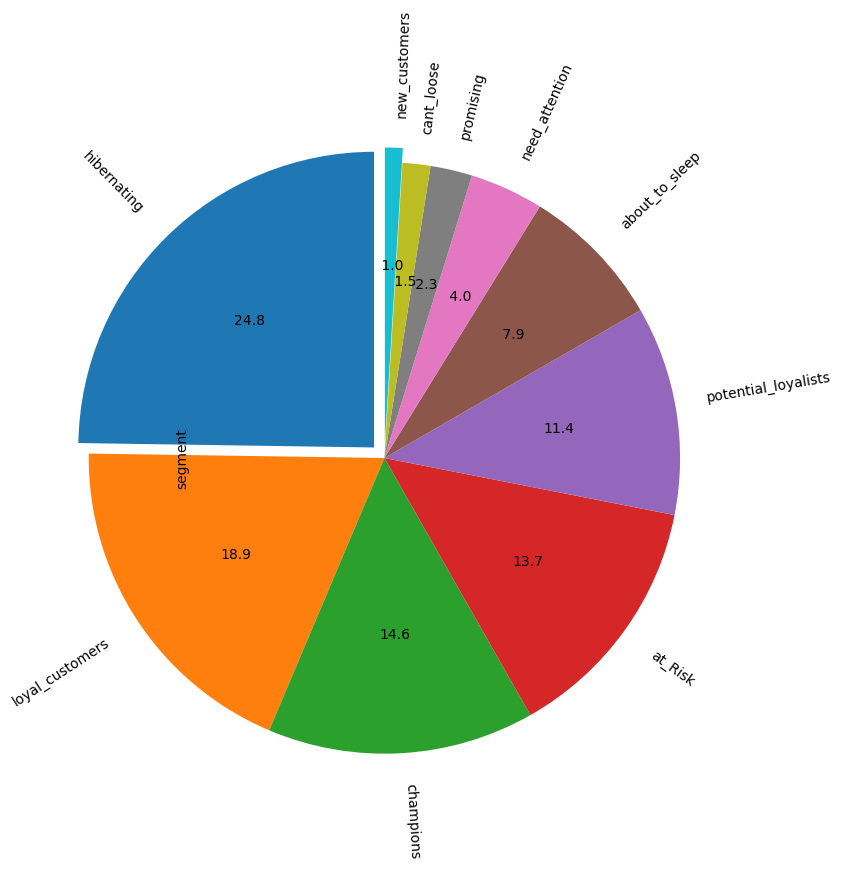

In [15]:
explodes = [0.10, 0, 0, 0, 0, 0, 0, 0, 0, 0.1]
rfm_df["segment"].value_counts(sort=True).plot.pie(
                                                 textprops={'fontsize': 10}, 
                                                 autopct = '%4.1f',
                                                 startangle= 90, 
                                                 radius =2,
                                                 rotatelabels=True, 
                                                 explode = explodes)

rfm_df.groupby('segment').agg({"Customer ID":"count"}).sort_values("Customer ID",ascending=False)

# Create csv

In [16]:
# We can choose the group we want and create csv like this.
attention_df = rfm_df[rfm_df["segment"] =="need_attention"]
attention_df.reset_index(inplace= True)
attention_df.drop("index",axis = 1,inplace = True)
attention_df.to_csv("need_attention.csv")

attention_df.head()

,Customer ID,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,rf_score,rfm_score,segment
0,12360.0,52,3,2395.16,3,3,5,33,335,need_attention
1,12413.0,67,3,758.10,3,3,3,33,333,need_attention
2,12456.0,44,3,2895.22,3,3,5,33,335,need_attention
3,12536.0,43,3,12373.44,3,3,5,33,335,need_attention
4,12577.0,35,3,599.53,3,3,3,33,333,need_attention
